In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm

from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

import copy


In [2]:
# set seed
np.random.seed(0)

In [3]:
# load data
data = Image.open('./figures/bayes.bmp')
img = np.double(data)
img_mean = np.mean(img)
img_binary = +1*(img>img_mean) + -1*(img<img_mean)
[M, N] = img_binary.shape

print(f"Size of image: {M}-by-{N}")

Size of image: 310-by-419


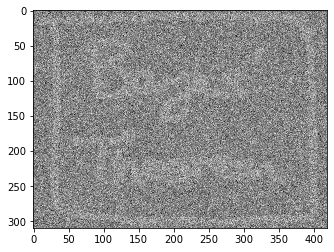

In [10]:
# add noise
sigma  = 3.5  #noise level
y      = img_binary + sigma*np.random.randn(M, N) #y_i ~ N(x_i; sigma^2);
plt.imshow(y,cmap='Greys', interpolation='nearest')

In [11]:
J        = 1.0  #coupling strength (w_ij)
rate     = 0.5  #update smoothing rate
max_iter = 70
ELBO     = np.zeros(max_iter)
ELBO_alt = np.zeros(max_iter) # alternative way to compute it
Hx_mean  = np.zeros(max_iter)

# alternative approach
def log_like(mu,J):
    # obtain shape of mu
    M,N      = mu.shape
    # accumulate loglike
    log_like = 0.0
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])         
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])         
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]  
            xx, yy = np.unravel_index(pos, (M,N), order='F')          # index of current pixel
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F') # indices of pixel's neighbors

            # compute loglike
            log_like += mu[xx,yy] * J * np.sum(mu[nx,ny])
    
    return log_like
            


In [12]:
#Mean-Field VI
logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

#init
p1 = sigmoid(logodds)
#mu = 2*p1-1  #mu_init
mu  = np.zeros(shape=(M,N))

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    #muNew = mu
    muNew = copy.deepcopy(mu)
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])         
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            #print(f"BEFORE ix:{ix},iy:{iy},pos:{pos},neighborhood:{neighborhood}") 
            neighborhood = neighborhood[np.where(boundary_idx)[0]]  
                    
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            #print(f"AFTER ix:{ix},iy:{iy},pos:{pos},neighborhood:{neighborhood}")    
            #print(f"xx:{xx},yy:{yy}")
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            #print(f"nx:{nx},ny:{ny}")
            Sbar = J*np.sum(mu[nx,ny])       
            #muNew[xx,yy] = (1-rate)*muNew[xx,yy] + rate*np.tanh(Sbar + 0.5*logodds[xx,yy])
            muNew[xx,yy] = np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])
        #end for
    #end for
    #mu = muNew # this is a fully updated mu
    mu = copy.deepcopy(muNew) # this is a fully updated mu
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx)   

    # alternative calculation of ELBO
    ELBO_alt[i] = log_like(mu,J) + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
             

100%|██████████| 70/70 [09:09<00:00,  7.85s/it]


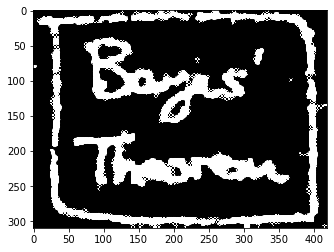

In [13]:
# plot denoised image
plt.imshow(mu,cmap='Greys', interpolation='nearest')

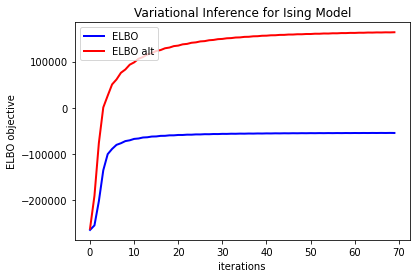

In [14]:
# plot ELBO
plt.figure()
plt.plot(ELBO, color='b', lw=2.0, label='ELBO')
plt.plot(ELBO_alt, color='r', lw=2.0, label='ELBO alt')
plt.title('Variational Inference for Ising Model')
plt.xlabel('iterations'); plt.ylabel('ELBO objective')
plt.legend(loc='upper left')

In [ ]:
x = np.array([1, 2, 3])
y = x

print(f"x:{x},y:{y}")

x[0] = 10
print(f"x:{x},y:{y}")

y[1] = 100
print(f"x:{x},y:{y}")
